In [2]:
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import new_alg_v2 as na2
import matplotlib.pyplot as plt
import math
from torchvision.datasets import MNIST, FashionMNIST
from torchvision import transforms
from tqdm import tqdm
torch.set_default_dtype(torch.float64)

In [3]:
def define_dataloaders(n_examples_train, n_examples_test, batch_size, classes=np.arange(10), zscore_images=True):
    # MNIST data, batch training
    #batch_size = n_examples_train

    # Choose the classes (at most 10)
    assert max(classes) <= 9

    # Transformation for the images
    transform = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((0.5,), (0.5,)),
                                  ])
    trainset = MNIST(data_dir, download=True, train=True, transform=transform)
    testset = MNIST(data_dir, download=True, train=False, transform=transform)

    # Obtain training and test data. 
    # Note that both datasets are sorted, but the train and test loaders will shuffle them during training.
    n_examples_tt = [n_examples_train, n_examples_test]
    for i_d, (n_examples_i, dataset) in enumerate(zip(n_examples_tt, [trainset, testset])):
        n_per_class = n_examples_i // len(classes)
        data_orig = dataset.data.detach().clone()
        targets_orig = dataset.targets.detach().clone()
        for i_c, class_i in enumerate(classes):
            mask = targets_orig == class_i
            i0 = i_c * n_per_class
            i1 = (i_c+1) * n_per_class
            dataset.data[i0:i1] = data_orig[mask][:n_per_class]
            dataset.targets[i0:i1] = targets_orig[mask][:n_per_class]
        # Fill the remaining slots with random classes from the available choices
        n_remain = n_examples_i - i1 
        for i in range(n_remain):
            class_i = np.random.choice(classes)
            mask = targets_orig == class_i
            idx_i = np.random.choice(torch.where(mask)[0].cpu())
            dataset.data[i1+i] = data_orig[idx_i]
            dataset.targets[i1+i] = targets_orig[idx_i]

        # Cut off
        dataset.data = dataset.data[:n_examples_i]
        dataset.targets = dataset.targets[:n_examples_i]

    # Batch-loader
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
    testloader = torch.utils.data.DataLoader(testset, batch_size=n_examples_test, shuffle=False, num_workers=0)

    return trainloader, testloader

In [4]:
data_dir = '/files/'
batch_size = 64
n_examples_train = 1*batch_size
n_examples_test = 1*batch_size

train_loader, test_loader =  define_dataloaders(n_examples_train, n_examples_test, batch_size)

for (data,target) in train_loader:
    d = data
    t = target

In [5]:
def calc_output_dim(input_H, input_W, kernel_size, pooling):

    # calc the parameters of the conv1 out put:
    H_out_conv1= math.floor(input_H-kernel_size+1)
    W_out_conv1= math.floor(input_W-kernel_size+1)

    # calc the dim after the pooling:
    pool_H_out= math.floor(((H_out_conv1-pooling)/pooling)+1)
    pool_W_out= math.floor(((W_out_conv1-pooling)/pooling)+1)

    # calc the parameters of the conv2 out put:
    H_out_conv2= math.floor(pool_H_out-kernel_size+1)
    W_out_conv2= math.floor(pool_W_out-kernel_size+1)

    # calc the dim after the pooling:
    pool2_H_out= math.floor(((H_out_conv2-pooling)/pooling)+1)
    pool2_W_out= math.floor(((W_out_conv2-pooling)/pooling)+1)

    # clac the dim of nn.Linear
    final_dim=pool2_H_out*pool2_W_out
    return final_dim

In [6]:
class CNN(nn.Module):
    def __init__(self, n_ch, n_classes, final_dim):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(n_ch, 1, kernel_size=kern_size, bias=False)
        self.conv2 = nn.Conv2d(1, 1, kernel_size=kern_size, bias=False)
        self.fc1 = nn.Linear(final_dim, final_dim, bias=False)
        self.fc2= nn.Linear(final_dim, n_classes, bias=False)

    def forward(self, x):
        final_dim = self.fc1.in_features
        x =torch.tanh( F.max_pool2d(self.conv1(x),pool_size))
        x = torch.tanh(F.max_pool2d(self.conv2(x),pool_size))
        x = x.view(-1, final_dim)
        x = torch.tanh(self.fc1(x))
        x= self.fc2(x)
        return x

In [7]:
def train(net, eta, n_epoch, dataset, target):
    train_losses = []
    net.train()
    loss = nn.CrossEntropyLoss()
    optimizer = na2.new_alg(net.parameters(), lr=eta)
    for epoch in range(n_epoch):
        optimizer.zero_grad()
        py_hat = net(dataset)
        objective = loss(py_hat, torch.flatten(target))
        train_losses.append(float(objective))
        objective.backward()
        optimizer.step()
    return train_losses

In [8]:
def test(net, dataset, target):
    net.eval()
    loss = nn.CrossEntropyLoss()
    with torch.no_grad():
        output = net(dataset)
        test_loss = loss(output, torch.flatten(target))
    return float(test_loss)

In [9]:
# parameters
n_s = 64 # number of sample
n_ch = 1 # number of input channels 
d0 = 28 # dim0 of input image
d1 = 28 # dim1 of input image
fc2_in= 10
n_epoch = 1
output_dim = n_s
kern_size=5
pool_size=2
n_classes = 10

# dataset
#DS = torch.normal(0, 1, size=(n_s, n_ch, d0, d1))
#target = torch.ones(output_dim,1)


In [10]:
def xl_calc(eta, n_ch, d0, d1, kern_size, pool_size, dataset, target):

    #define the net and save init params
    final_dim = calc_output_dim(d0, d1, kern_size, pool_size)
    network = CNN(n_ch, n_classes, final_dim)
    conv1_init = network.conv1.weight.clone()
    conv2_init = network.conv2.weight.clone()
    fc1_init = network.fc1.weight.clone()
    fc2_init = network.fc2.weight.clone()


    #train and save init and final loss
    initial_loss = test(network, dataset, target)
    test_loss = train(network, eta, n_epoch, dataset, target)
    final_loss = test(network, dataset, target)

    #save final net params
    conv1_final = network.conv1.weight.clone()
    conv2_final = network.conv2.weight.clone()
    fc1_final = network.fc1.weight.clone()
    fc2_final = network.fc2.weight.clone()

    #init weights conv1
    with torch.no_grad():
      network.conv1.weight[:] = conv1_init
    loss_conv1 = test(network, dataset, target)
        
    #init weights conv2
    with torch.no_grad():
      network.conv1.weight[:] = conv1_final
      network.conv2.weight[:] = conv2_init
    loss_conv2 = test(network, dataset, target)
    
    #init weights fc1
    with torch.no_grad():
      network.conv2.weight[:] = conv2_final
      network.fc1.weight[:] = fc1_init
    loss_fc1 = test(network, dataset, target)

    #init weights fc2
    with torch.no_grad():
      network.fc1.weight[:] = fc1_final
      network.fc2.weight[:] = fc2_init

    loss_fc2 = test(network, dataset, target)
    
    dL = final_loss - initial_loss
    #print("for lr =",  eta, ":")
    #print("  inital loss = ", initial_loss)
    #print("  final loss = ", final_loss)
    if dL == 0:
      #print("for lr =",  eta, ":")
      #print("   ***dL zero***")
      return
    
    Xl_conv1 = (final_loss - loss_conv1)/dL
    Xl_conv2 = (final_loss - loss_conv2)/dL
    Xl_fc1 = (final_loss-loss_fc1)/dL
    Xl_fc2 = (final_loss-loss_fc2)/dL

    return Xl_conv1, Xl_conv2, Xl_fc1 ,Xl_fc2
    

In [11]:
n_lrs = 50
lrs = np.logspace(0,-4,n_lrs)
conv1=[]
conv2=[]
fc1=[]
fc2=[]

for lr in lrs:
  x1 ,x2 ,x3, x4 = xl_calc(lr, n_ch, d0, d1, kern_size, pool_size, data, target)

  conv1.append(abs((1/4)-x1))
  conv2.append(abs((1/4)-x2))
  fc1.append(abs((1/4)-x3))
  fc2.append(abs((1/4)-x4))

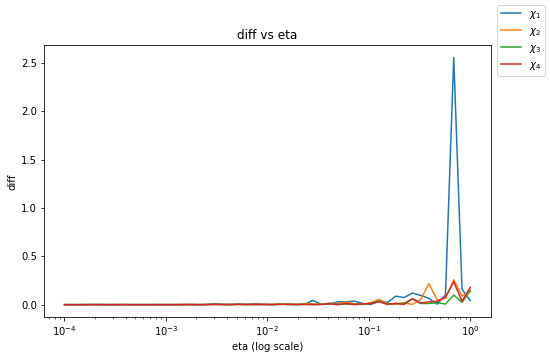

In [12]:
#plotting results
fig = plt.figure(figsize=(8, 5))
plt.plot(lrs,conv1,label="$χ_{1}$")
plt.plot(lrs,conv2, label="$χ_{2}$")
plt.plot(lrs,fc1, label= "$χ_{3}$")
plt.plot(lrs,fc2, label= "$χ_{4}$")
plt.xscale('log')
#plt.yscale('log')

plt.ylabel('diff')
plt.xlabel('eta (log scale)')
plt.title("diff vs eta")
fig.legend()


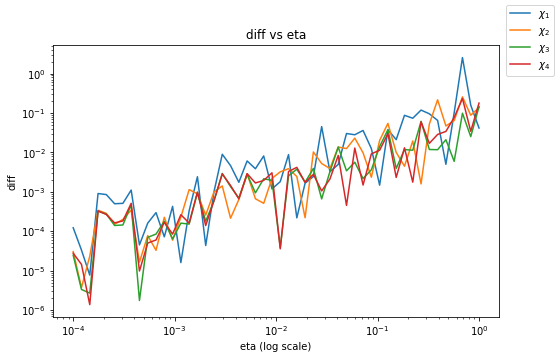

In [13]:
#plotting results
fig = plt.figure(figsize=(8, 5))
plt.plot(lrs,conv1,label="$χ_{1}$")
plt.plot(lrs,conv2, label="$χ_{2}$")
plt.plot(lrs,fc1, label= "$χ_{3}$")
plt.plot(lrs,fc2, label= "$χ_{4}$")
plt.xscale('log')
plt.yscale('log')

plt.ylabel('diff')
plt.xlabel('eta (log scale)')
plt.title("diff vs eta")
fig.legend()


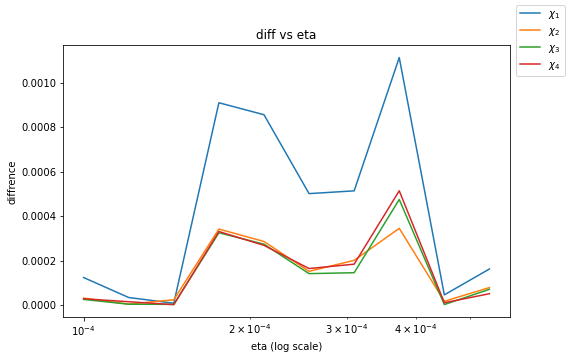

In [20]:
#plotting results, ***ZOMM IN***
a = 40
b = 50
fig = plt.figure(figsize=(8, 5))
plt.plot(lrs[a:b],conv1[a:b],label="$χ_{1}$")
plt.plot(lrs[a:b],conv2[a:b], label="$χ_{2}$")
plt.plot(lrs[a:b],fc1[a:b], label= "$χ_{3}$")
plt.plot(lrs[a:b],fc2[a:b], label= "$χ_{4}$")
plt.xscale('log')

plt.ylabel('diffrence')
plt.xlabel('eta (log scale)')
plt.title("diff vs eta")
fig.legend()


In [16]:
res = np.zeros((4,n_lrs))
it = 100
for k in tqdm(range(it)):
  for j,lr in enumerate(lrs):
    x1 ,x2 ,x3, x4 = xl_calc(lr, n_ch, d0, d1, kern_size, pool_size, data, target)
    res[0,j] += (1/it)*abs(0.25-x1)
    res[1,j] += (1/it)*abs(0.25-x2)
    res[2,j] += (1/it)*abs(0.25-x3)
    res[3,j] += (1/it)*abs(0.25-x4)

100%|██████████| 100/100 [01:19<00:00,  1.27it/s]


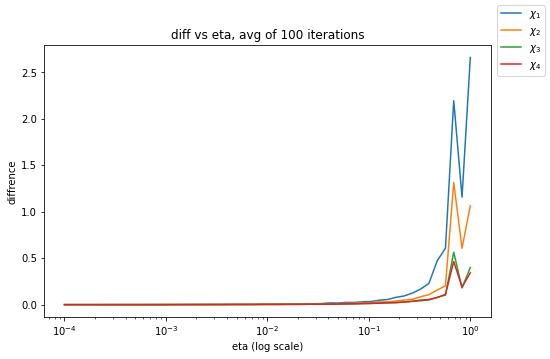

In [17]:
#plotting results 100 it
fig = plt.figure(figsize=(8, 5))
plt.plot(lrs,res[0,:],label="$χ_{1}$")
plt.plot(lrs,res[1,:], label="$χ_{2}$")
plt.plot(lrs,res[2,:], label= "$χ_{3}$")
plt.plot(lrs,res[3,:], label= "$χ_{4}$")
plt.xscale('log')

plt.ylabel('diffrence')
plt.xlabel('eta (log scale)')
title_srt = "diff vs eta, avg of " + str(it) + " iterations"
plt.title(title_srt)
fig.legend()
